In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sklearn.model_selection as train_test_split
from torch.utils.data import dataset, DataLoader
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
N_train = 3000
N_test  = 9000

X_train = X_train[:N_train]
y_train = y_train[:N_train]
X_test  = X_test[:N_test]
y_test  = y_test[:N_test]

X_train.shape

In [ ]:
_, counts_train = np.unique(y_train, return_counts=True)
_, counts_test  = np.unique(y_test,  return_counts=True)

print("Train counts per class:", counts_train)
print("Test counts per class: ", counts_test)


In [ ]:
np.unique(y_test)

In [ ]:
X_test.shape

In [ ]:
plt.imshow(X_test[1])

In [ ]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0


X_test[10]

In [ ]:
class My_Dataset(dataset.Dataset):
    def __init__(self,x,y):
      self.X = torch.tensor(x, dtype=torch.float32)
      self.Y = torch.tensor(y, dtype=torch.float32)

    def __getitem__(self,idx):
      return self.X[idx], self.Y[idx]

    def __len__(self):
      return len(self.X)

In [ ]:
training_Dataset = My_Dataset(X_train, y_train)
testing_Dataset = My_Dataset(X_test, y_test)

training_dataloader = DataLoader(training_Dataset, batch_size=64, shuffle=True)
testing_dataloader = DataLoader(testing_Dataset, batch_size =64, shuffle = True)

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=3, stride=1, padding=1),  # 32×32→32×32
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Conv2d(20, 20, kernel_size=3, stride=1, padding=1),  # 32×32→32×32
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                                    # 32×32→11×11

            nn.Conv2d(20, 40, kernel_size=3, stride=1, padding=1),# 11×11→11×11
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.Conv2d(40, 40, kernel_size=3, stride=1, padding=1),# 11×11→11×11
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                                    # 11×11→5×5
        )
        # flatten size = 128 * 5 * 5 = 3200
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(40 * 8 * 8, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
X_train.shape

In [ ]:
input_dim = X_train.shape
model = MyCNN()


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters())


In [ ]:
training_loss_per_epoch = []
testing_loss_per_epoch = []
training_acc_per_epoch = []
testing_acc_per_epoch = []


for epoch in range(35):
    total_cost    = 0.0
    total_correct = 0


    for batch_x, batch_y in training_dataloader:

        model.train()

        optimizer.zero_grad()


        batch_x = batch_x.permute(0, 3, 1, 2)
        batch_y = batch_y.long()
        batch_y = batch_y.squeeze(1)


        logits = model(batch_x)
        loss   = criterion(logits, batch_y)

        loss.backward()
        optimizer.step()


        total_cost    += loss.item()
        preds          = torch.argmax(logits, dim=1)
        total_correct += (preds == batch_y).sum().item()

    avg_cost = total_cost / len(training_dataloader)
    acc      = total_correct / len(training_dataloader.dataset)

    training_loss_per_epoch.append(avg_cost)
    training_acc_per_epoch.append(acc)
    print(f"Epoch {epoch+1:2d}: loss={avg_cost:.4f}, acc={acc:.4%}")
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    test_loss = 0.0
    total_testing_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in testing_dataloader:
              batch_x = batch_x.permute(0, 3, 1, 2)
              batch_y = batch_y.long()
              batch_y = batch_y.squeeze(1)
              logits = model(batch_x)
              test_preds  = torch.argmax(logits, dim=1)
              test_loss   = criterion(logits, batch_y)
              correct += (test_preds == batch_y).sum().item()
              all_preds.extend(test_preds.cpu().numpy())
              all_labels.extend(batch_y.cpu().numpy())
              total_testing_loss    += test_loss.item()

        avg_loss = total_testing_loss  / len(training_dataloader)
        val_accuracy = correct / len(testing_dataloader.dataset)
        testing_acc_per_epoch.append(val_accuracy)
        testing_loss_per_epoch.append(avg_loss)
        print(f"Test loss={avg_loss:.4f}, Test acc= {val_accuracy:.4%}")



Epoch  1: loss=2.7162, acc=18.9333%
Test loss=6.2479, Test acc= 25.2667%
Epoch  2: loss=2.0069, acc=26.2000%
Test loss=5.6978, Test acc= 30.7667%
Epoch  3: loss=1.8439, acc=32.9333%
Test loss=5.1992, Test acc= 38.3222%
Epoch  4: loss=1.7230, acc=37.6000%
Test loss=5.1653, Test acc= 39.2111%
Epoch  5: loss=1.6458, acc=39.0333%
Test loss=4.7718, Test acc= 44.3667%
Epoch  6: loss=1.5283, acc=43.9333%
Test loss=5.1700, Test acc= 41.1444%
Epoch  7: loss=1.4917, acc=44.4667%
Test loss=4.3326, Test acc= 47.5444%
Epoch  8: loss=1.4204, acc=47.1667%
Test loss=4.3457, Test acc= 47.7778%
Epoch  9: loss=1.3878, acc=48.8333%
Test loss=4.2562, Test acc= 49.0889%
Epoch 10: loss=1.3403, acc=50.7667%
Test loss=4.3352, Test acc= 47.1889%
Epoch 11: loss=1.3081, acc=51.8000%
Test loss=4.1886, Test acc= 49.7778%
Epoch 12: loss=1.2512, acc=53.4667%
Test loss=4.5919, Test acc= 46.8000%
Epoch 13: loss=1.2082, acc=55.7333%
Test loss=4.1149, Test acc= 50.4667%
Epoch 14: loss=1.1808, acc=56.7667%
Test loss=4.438

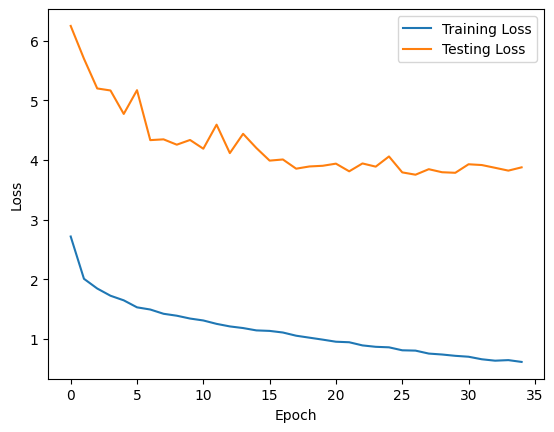

In [ ]:
plt.plot(training_loss_per_epoch, label='Training Loss')
plt.plot(testing_loss_per_epoch, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

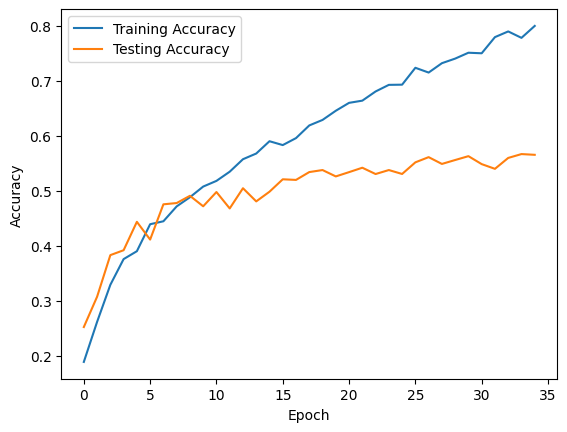

In [ ]:
plt.plot(training_acc_per_epoch, label='Training Accuracy')
plt.plot(testing_acc_per_epoch , label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print(f"Num labels:      {len(all_labels)}")
print(f"Num predictions: {len(all_preds)}")


Num labels:      9000
Num predictions: 9000


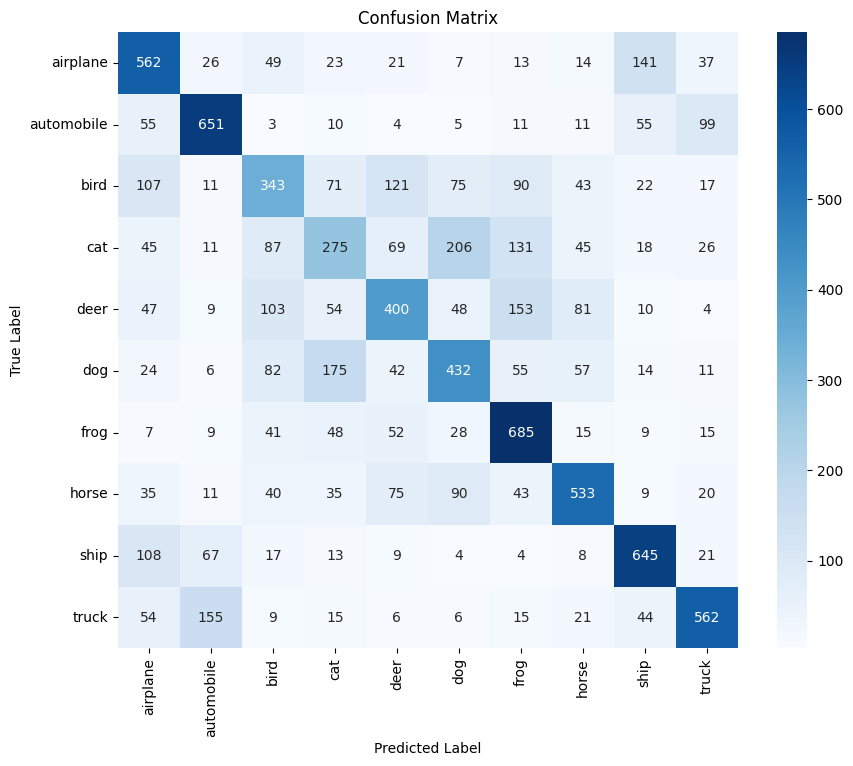

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

# Plot using seaborn
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()